In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers 

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
#Load processed data

PROJECT_ROOT=os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_PROCESSED_DIR=os.path.join(PROJECT_ROOT,'data','processed')
OUTPUT_DIR=os.path.join(PROJECT_ROOT,'outputs')
os.makedirs(OUTPUT_DIR,exist_ok=True)

df=pd.read_csv(os.path.join(DATA_PROCESSED_DIR,'aqi_processed_data.csv'))
df['Timestamp']=pd.to_datetime(df['Timestamp'])
df=df.sort_values(['City','Timestamp']).reset_index(drop=True)

df.head()

,Timestamp,City,PM2.5,PM10,NO2,NH3,CO,SO2,O3,PM2.5_was_missing,PM10_was_missing,NO2_was_missing,NH3_was_missing,CO_was_missing,SO2_was_missing,O3_was_missing,AQI,n_avail_sub
0,2020-01-01,Bengaluru,43.67,134.00,20.28,10.98,0.91,3.41,21.82,1,1,1,1,1,1,1,122.926174,7
1,2020-01-02,Bengaluru,43.67,134.00,20.28,10.98,0.91,3.41,21.82,0,0,0,0,0,0,0,122.926174,7
2,2020-01-03,Bengaluru,30.58,74.42,15.17,12.10,0.96,3.27,23.31,0,0,0,0,0,0,0,74.420000,6
3,2020-01-04,Bengaluru,66.35,155.68,42.90,11.75,2.54,3.26,29.70,0,0,0,0,0,0,0,137.331007,7
4,2020-01-05,Bengaluru,48.00,99.13,18.56,9.79,1.14,2.95,31.01,0,0,0,0,0,0,0,99.130000,7


In [4]:
TRAIN_END=pd.Timestamp('2023-12-31')
VAL_END=pd.Timestamp('2024-06-30')

df['split']='test'
df.loc[df['Timestamp']<=VAL_END,'split']='val'
df.loc[df['Timestamp']<=TRAIN_END,'split']='train'

df['split'].value_counts()

split
train    4383
test      552
val       546
Name: count, dtype: int64

In [5]:
LOOKBACK=14
HORIZON=1

POLUT_COL=['PM2.5','PM10','NO2','SO2','NH3','CO','O3']
MISSING_FLAG_COL=[f"{c}_was_missing" for c in POLUT_COL]

#calender features
df['dow']=df['Timestamp'].dt.dayofweek
df['month']=df['Timestamp'].dt.month

FEATURE_COLS=['AQI']+POLUT_COL+MISSING_FLAG_COL+['dow','month']
TARGET_COL='AQI'

FEATURE_COLS

['AQI',
 'PM2.5',
 'PM10',
 'NO2',
 'SO2',
 'NH3',
 'CO',
 'O3',
 'PM2.5_was_missing',
 'PM10_was_missing',
 'NO2_was_missing',
 'SO2_was_missing',
 'NH3_was_missing',
 'CO_was_missing',
 'O3_was_missing',
 'dow',
 'month']

In [6]:
def rmse(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def smape(y_true,y_pred,eps=1e-8):
    y_true=np.asarray(y_true)
    y_pred=np.asarray(y_pred)
    denom=(np.abs(y_true)+np.abs(y_pred))+eps/2.0
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

In [7]:
#create sequences
def make_sequences(X:np.ndarray,y:np.ndarray,lookback:int,horizon:int):
    Xs,ys=[],[]

#y[t] is target aligned with X window ending at t-1(predict t+horizon)
    for i in range(lookback,len(X)-horizon+1):
     start=i-lookback
     Xs.append(X[start:i])
     ys.append(y[i+horizon-1])
    return np.array(Xs),np.array(ys)

In [8]:
def prepare_city_data(city_df:pd.DataFrame,lookback:int,horizon:int):
    city_df=city_df.sort_values("Timestamp").reset_index(drop=True)

    train_mask=city_df["split"]=="train"
    X_all=city_df[FEATURE_COLS].to_numpy(dtype=np.float32)
    y_all=city_df[TARGET_COL].to_numpy(dtype=np.float32).reshape(-1, 1)

    # Scale X on train only
    x_scaler=StandardScaler()
    x_scaler.fit(X_all[train_mask])
    X_all_scaled=x_scaler.transform(X_all).astype(np.float32)

    # Scale y on train only
    y_scaler=StandardScaler()
    y_scaler.fit(y_all[train_mask])
    y_all_scaled=y_scaler.transform(y_all).astype(np.float32).ravel()

    # Sequences(X scaled,y scaled)
    X_seq,y_seq=make_sequences(X_all_scaled,y_all_scaled,lookback,horizon)

    target_time=city_df["Timestamp"].iloc[lookback+horizon-1:].reset_index(drop=True)
    target_split=city_df["split"].iloc[lookback+horizon-1:].reset_index(drop=True)

    return X_seq,y_seq,target_time.to_numpy(),target_split.to_numpy(),x_scaler,y_scaler


In [9]:
def build_lstm(input_shape):
    model=keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64,return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(32,activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),loss='mse')
    return model

def build_gru(input_shape):
    model=keras.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(64,return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(32,activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),loss='mse')
    return model

In [10]:
# training loop per city + evaluation
early_stop=keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

all_results=[]
all_preds=[]

for city,g in df.groupby("City"):
    X_seq,y_seq,t_seq,split_seq,x_scaler,y_scaler=prepare_city_data(g,LOOKBACK,HORIZON)

    X_train,y_train=X_seq[split_seq=="train"],y_seq[split_seq=="train"]
    X_val,y_val=X_seq[split_seq=="val"],y_seq[split_seq=="val"]
    X_test, y_test=X_seq[split_seq=="test"],y_seq[split_seq=="test"]

    print(city,"Shapes:",X_train.shape,X_val.shape,X_test.shape)

    input_shape=(X_train.shape[1],X_train.shape[2])

    for model_name,builder in [("LSTM",build_lstm),("GRU",build_gru)]:
        model=builder(input_shape)

        history=model.fit(
            X_train,y_train,
            validation_data=(X_val,y_val), 
            epochs=100,
            batch_size=32,
            verbose=0,
            callbacks=[early_stop]
        )

        # Evaluation
        for split_name,Xs,ys in [("val",X_val,y_val),("test",X_test,y_test)]:
            pred_scaled=model.predict(Xs,verbose=0).ravel()

            pred=y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
            ys_orig=y_scaler.inverse_transform(ys.reshape(-1, 1)).ravel()

            all_results.append({
                "City":city,
                "Model":model_name,
                "Split":split_name,
                "MAE":mean_absolute_error(ys_orig,pred),
                "RMSE":rmse(ys_orig,pred),
                "sMAPE":smape(ys_orig,pred),
                "n":len(ys_orig),
                "epochs_ran":len(history.history["loss"])
            })

            if split_name=="test":
                idx=(split_seq=="test")
                times=pd.to_datetime(t_seq[idx])

                pred_df=pd.DataFrame({
                    "City":city,
                    "Timestamp":times,
                    "y_true":ys_orig,
                    "y_pred":pred,
                    "Model":model_name
                })
                all_preds.append(pred_df)

        # Save learning curve for GitHub
        hist_df=pd.DataFrame(history.history)
        hist_path=os.path.join(OUTPUT_DIR,f"{city}_{model_name}_history.csv")
        hist_df.to_csv(hist_path,index=False)

results_dl=pd.DataFrame(all_results)
preds_dl=pd.concat(all_preds,ignore_index=True)

results_dl


Bengaluru Shapes: (1447, 14, 17) (182, 14, 17) (184, 14, 17)
Delhi Shapes: (1447, 14, 17) (182, 14, 17) (184, 14, 17)
Mumbai Shapes: (1447, 14, 17) (182, 14, 17) (184, 14, 17)


,City,Model,Split,MAE,RMSE,sMAPE,n,epochs_ran
0,Bengaluru,LSTM,val,30.566143,61.289498,14.189575,182,100
1,Bengaluru,LSTM,test,27.981318,34.739051,16.505308,184,100
2,Bengaluru,GRU,val,30.703091,61.420770,14.269350,182,10
3,Bengaluru,GRU,test,28.046915,34.831663,16.547073,184,10
4,Delhi,LSTM,val,46.930305,60.349545,10.914482,182,19
5,Delhi,LSTM,test,39.052319,49.845087,11.353283,184,19
6,Delhi,GRU,val,45.101540,56.981459,10.515913,182,12
7,Delhi,GRU,test,32.855587,43.868858,9.667525,184,12
8,Mumbai,LSTM,val,30.112873,37.405814,16.294474,182,10
9,Mumbai,LSTM,test,43.528992,51.183100,25.145632,184,10


In [11]:
results_dl.to_csv(os.path.join(OUTPUT_DIR,'dl_results_lstm_gru.csv'),index=False)
preds_dl.to_csv(os.path.join(OUTPUT_DIR,'dl_test_predictions_lstm_gru.csv'),index=False)

preds_dl.head

<bound method NDFrame.head of            City  Timestamp      y_true      y_pred Model
0     Bengaluru 2024-07-01   64.250000   82.448669  LSTM
1     Bengaluru 2024-07-02   81.440002   82.448669  LSTM
2     Bengaluru 2024-07-03   70.040001   82.448669  LSTM
3     Bengaluru 2024-07-04  101.292351   82.448669  LSTM
4     Bengaluru 2024-07-05   67.400002   82.448669  LSTM
...         ...        ...         ...         ...   ...
1099     Mumbai 2024-12-27  149.603027  115.798820   GRU
1100     Mumbai 2024-12-28  169.276779  115.798820   GRU
1101     Mumbai 2024-12-29  140.626572  115.798820   GRU
1102     Mumbai 2024-12-30  111.717247  115.798820   GRU
1103     Mumbai 2024-12-31  140.998657  115.798820   GRU

[1104 rows x 5 columns]>

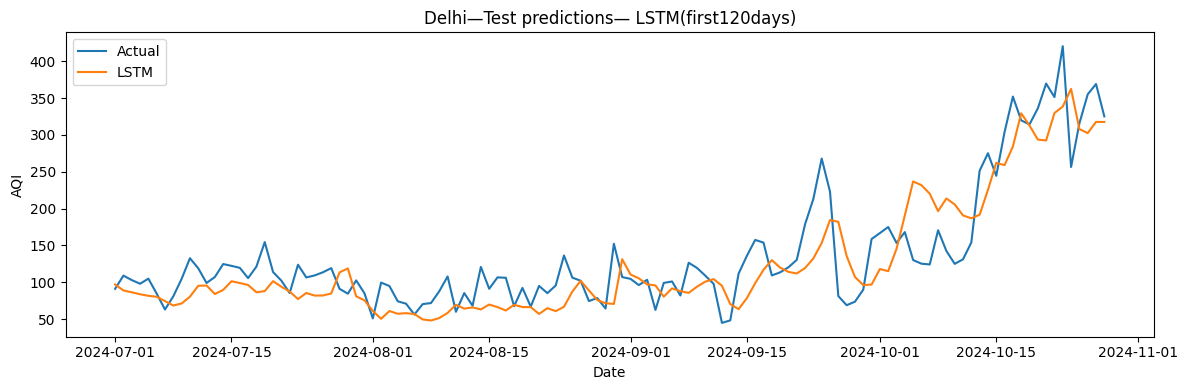

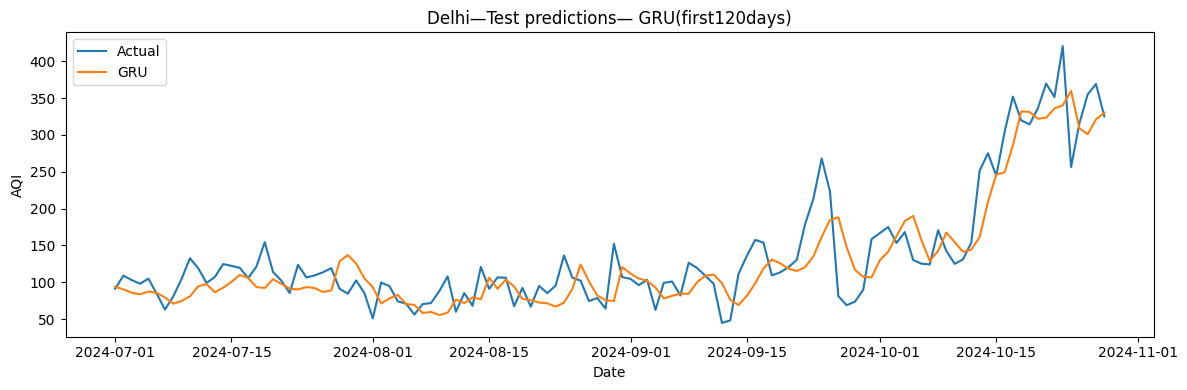

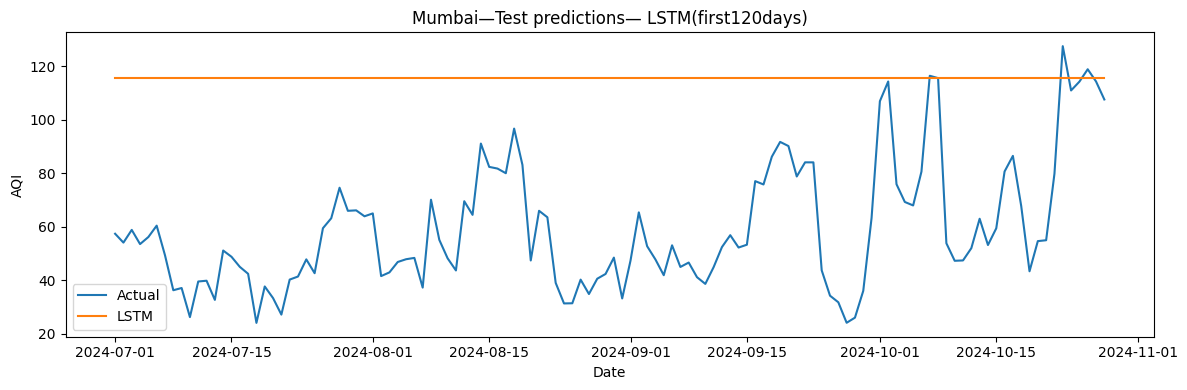

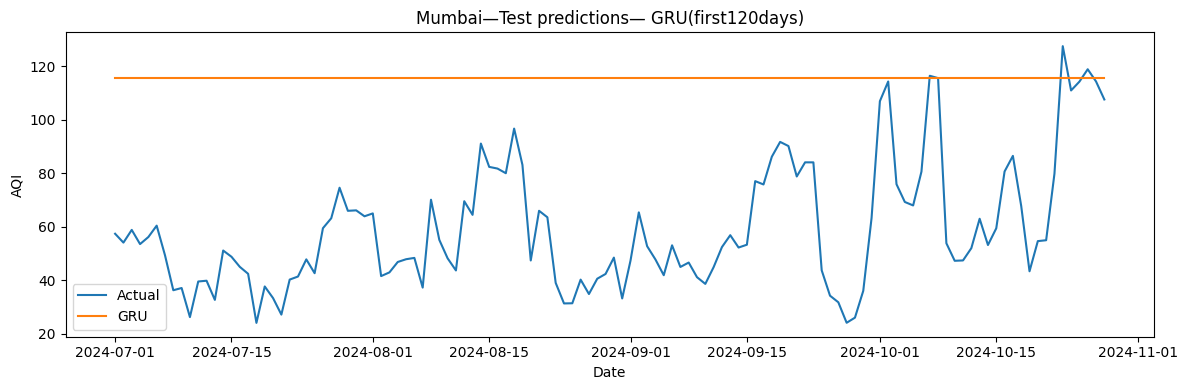

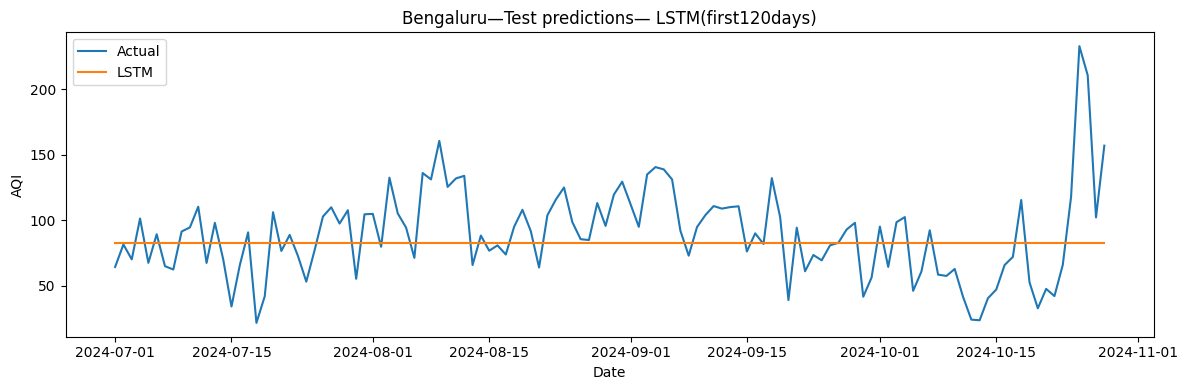

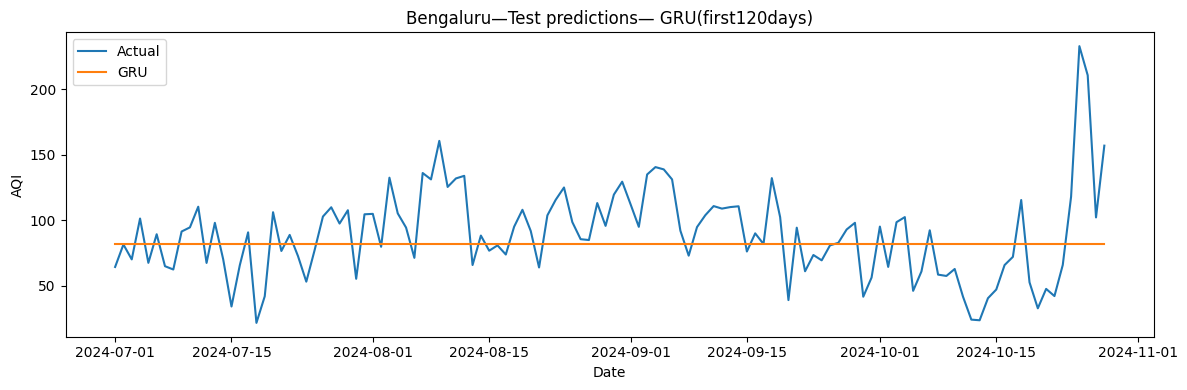

In [12]:
def plot_dl_predictions(city:str,model_name:str,n_days: int = 120):
    tmp=preds_dl[(preds_dl["City"]==city)&(preds_dl["Model"]==model_name)].copy()
    tmp=tmp.sort_values("Timestamp").head(n_days)

    plt.figure(figsize=(12,4))
    plt.plot(tmp["Timestamp"],tmp["y_true"],label="Actual")
    plt.plot(tmp["Timestamp"],tmp["y_pred"],label=model_name)
    plt.title(f"{city}—Test predictions— {model_name}(first{n_days}days)")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.legend()
    plt.tight_layout()
    plt.show()

for city in ["Delhi","Mumbai","Bengaluru"]:
    plot_dl_predictions(city,"LSTM",120)
    plot_dl_predictions(city,"GRU",120)
